## Install dependencies and setting up GPU Env

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
OK


In [2]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://pp

In [3]:
!pip install tensorflow-gpu==1.13.1

In [4]:
!pip install requests

## Imports

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'1.13.1'

## Dataset Preprocessing

load the dataset

In [0]:
(X_train,y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_train.shape

(50000, 32, 32, 3)

## Defining the model
Using 


In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu", input_shape = [32, 32 , 3]))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation="relu"))
model.add(tf.keras.layers.Dense(units=10, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
__________

## Compiling the model

In [0]:
model.compile(optimizer = 'Adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

### Training model

In [13]:
model.fit(X_train, y_train, batch_size = 128, epochs = 10)

Epoch 1/10
50000/50000 [==============================] - 13s 262us/sample - loss: 1.4819 - sparse_categorical_accuracy: 0.4642
Epoch 2/10
50000/50000 [==============================] - 12s 230us/sample - loss: 1.0504 - sparse_categorical_accuracy: 0.6294
Epoch 3/10
50000/50000 [==============================] - 11s 229us/sample - loss: 0.8676 - sparse_categorical_accuracy: 0.6966
Epoch 4/10
50000/50000 [==============================] - 11s 227us/sample - loss: 0.7436 - sparse_categorical_accuracy: 0.7414
Epoch 5/10
50000/50000 [==============================] - 11s 229us/sample - loss: 0.6363 - sparse_categorical_accuracy: 0.7788
Epoch 6/10
50000/50000 [==============================] - 11s 229us/sample - loss: 0.5444 - sparse_categorical_accuracy: 0.8101
Epoch 7/10
50000/50000 [==============================] - 11s 229us/sample - loss: 0.4649 - sparse_categorical_accuracy: 0.8371
Epoch 8/10
50000/50000 [==============================] - 11s 229us/sample - loss: 0.3820 - sparse_categ

### model evaluation

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 151us/sample - loss: 0.9999 - sparse_categorical_accuracy: 0.7359


In [15]:
print(f"test accuracy : {test_accuracy*100}%")

test accuracy : 73.58999848365784%


## Saving Model for Production

###Creating the directory for the model

In [0]:
MODEL_DIR = "model/"
version = 1

In [17]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
  !rm -r {export_path}

### Saving the model for the TensorFlow Serving

In [19]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


##Setting up the production environment 

### Exporing the MODEL_DIR to enviornment variables. 

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

###Running TensorFlow Serving REST API

In [21]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [22]:
!tail server.log

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                2019-08-

## Create the first POST request

In [23]:
random_image = np.random.randint(0,len(X_test))
random_image

3362

### Creating the JSON data object

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [25]:
data

'{"signature_name": "serving_default", "instances": [[[[0.08235294117647059, 0.03137254901960784, 0.09019607843137255], [0.07450980392156863, 0.043137254901960784, 0.09411764705882353], [0.050980392156862744, 0.03529411764705882, 0.0784313725490196], [0.06274509803921569, 0.08235294117647059, 0.15294117647058825], [0.07450980392156863, 0.11764705882352941, 0.23529411764705882], [0.10196078431372549, 0.13725490196078433, 0.27450980392156865], [0.09019607843137255, 0.12156862745098039, 0.23137254901960785], [0.09803921568627451, 0.1411764705882353, 0.25882352941176473], [0.10980392156862745, 0.1411764705882353, 0.2784313725490196], [0.06666666666666667, 0.06274509803921569, 0.16862745098039217], [0.08627450980392157, 0.10980392156862745, 0.24705882352941178], [0.08627450980392157, 0.15294117647058825, 0.30980392156862746], [0.058823529411764705, 0.09803921568627451, 0.1803921568627451], [0.08235294117647059, 0.09803921568627451, 0.20392156862745098], [0.09411764705882353, 0.0941176470588

Sending the first POST request to the model

In [0]:
headers = {"content-type":"application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers = headers)

In [28]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [30]:
predictions

[[3.07771963e-09,
  0.999990821,
  1.14064693e-12,
  1.36912495e-10,
  2.60699059e-16,
  3.65752086e-08,
  1.21617927e-06,
  6.08895e-14,
  1.17857351e-08,
  7.94131483e-06]]

In [31]:
predictions

[[3.07771963e-09,
  0.999990821,
  1.14064693e-12,
  1.36912495e-10,
  2.60699059e-16,
  3.65752086e-08,
  1.21617927e-06,
  6.08895e-14,
  1.17857351e-08,
  7.94131483e-06]]

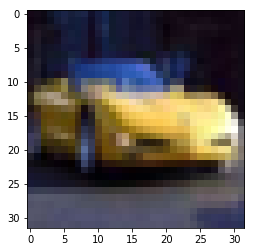

In [32]:
plt.imshow(X_test[random_image])

In [33]:
class_names[np.argmax(predictions[0])]

'automobile'

## Sending POST request to a specific model

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/model/cifar10/versions/1:predict",data=data,headers=headers)

In [35]:
specific_json_response

<Response [400]>